<a href="https://colab.research.google.com/github/ad17171717/YouTube-Tutorials/blob/main/Finance%20with%20Python/Finance_with_Python!_Option_Liquidity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# **Option Liquidity**

**In finance liquidity refers to the ease with which an asset can be bought or sold at minimum cost. For options contracts there are three metrics we will focus on for liquidity: bid-ask spread, the volume of options traded and open interest.**

- **The Bid-Ask Spread is the difference between the asking price a seller is quoting for an asset (ask) and the price a buyer is willing to purchase the asset for (bid). The difference between the asking price and the bidding price is the spread. Liquid assets have a smaller bid-ask spread while less liquid assets have a larger spread.**
- **The Total Volume is the number of call and put options contracts that are traded during a single trading day. The larger the volume of trading, the better the liquidity.**
- **For options, Open Interest is the number of options held by traders in active positions. Open interest decreases as investors that are long or short their position close it out. The more open interest there is for a contract the more liquid the contract.**

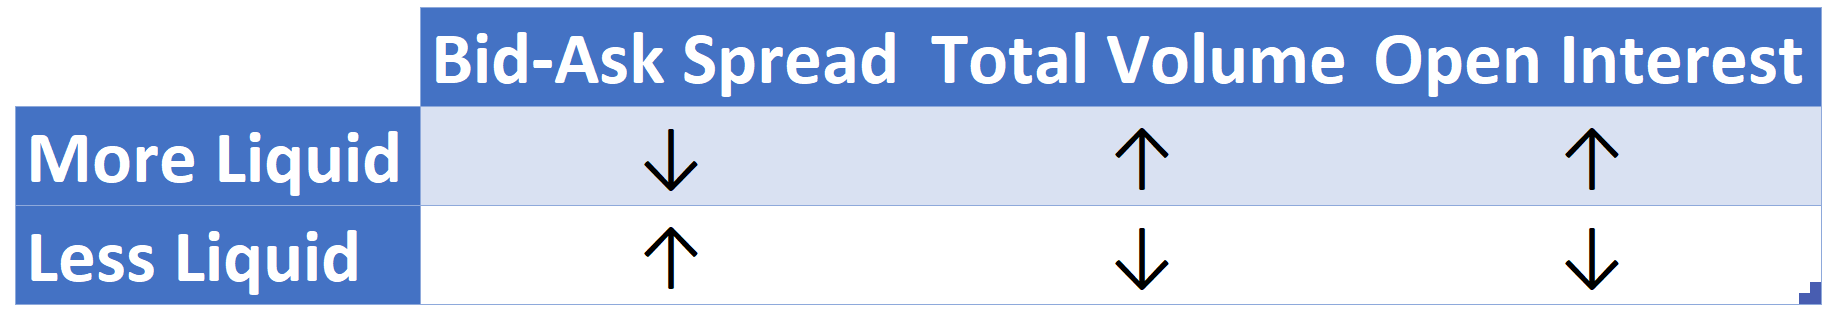

<sup/>Source: [The role of liquidity in financial markets](https://repositories.lib.utexas.edu/items/c5c40d0e-955a-4b5a-8ba7-864451ed3415) by Pavan Wadhwa<sup>

<sup/>Source: [Volume vs. Open Interest: What's the Difference?](https://www.investopedia.com/ask/answers/050615/what-difference-between-open-interest-and-volume.asp) by Steven Nickolas from Investopedia.com<sup>

## **Disclaimer**

**This notebook and tutorial are for educational purposes only and is not intended to be financial advice.**

**The tutorial provides a simple snapshot of options traded at a single point in time. A much more robust analysis would consider a variety of factors such as if there is an earnings announcement, trading costs and would provide a larger amount of sample points to analyze liquidity.**

## **Create a DataFrame to Store the Data**

In [ ]:
#scrape the constituents of the S&P 500 from Wikipedia
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [ ]:
#save company names and tickers into a dictionary
ticker_dict = {ticker: company for ticker, company in zip(df['Symbol'].values, df['Security'].values)}

#dictionary containing various option metrics for a given company
option_dict = {'Company':[],'Ticker':[],'Total Option Volume':[], 'Total Option Open Interest':[],
               'Stock Price':[] ,'Average ATM/ITM Call Bid-Ask Spread':[],'Average ATM/ITM Put Bid-Ask Spread':[]}

In [ ]:
for ticker, name in ticker_dict.items():
  #create a ticker instance for a given company
  company_data = yf.Ticker(ticker)

  try:
    #save the option chain into a pandas DataFrame
    option_data = company_data.option_chain()
    call_df,put_df = option_data[0],option_data[1]

    #retrieve the total volume of call/put options traded
    call_volume = int(call_df['volume'].sum())
    put_volume = int(put_df['volume'].sum())
    total_volume = call_volume + put_volume

    #retrieve the open interest for options
    call_interest = int(call_df['openInterest'].sum())
    put_interest = int(put_df['openInterest'].sum())
    total_interest = call_interest + put_interest

    #retrieve the last stock price for the company
    current_stock_prices = company_data.history(period='1d')
    stock_price = current_stock_prices['Close'][0]

    #retrieve the average bid ask spread across at-the-money and in-the-money call/put options
    #in the money call spread
    call_money = call_df[call_df['inTheMoney'] == True].iloc[-1]
    call_spread_itm = call_money['ask']-call_money['bid']
    #at the money call spread
    call_atm = call_df[call_df['inTheMoney'] == False].iloc[0]
    call_spread_atm = call_atm['ask']-call_atm['bid']
    #average of itm and atm spreads
    call_spread = (call_spread_itm+call_spread_atm)/2

    #in-the-money put spread
    put_money = put_df[put_df['inTheMoney'] == True].iloc[0]
    put_spread_itm = put_money['ask']-put_money['bid']
    #at-the-money put spread
    put_atm = put_df[put_df['inTheMoney'] == False].iloc[-1]
    put_spread_atm = put_atm['ask']-put_atm['bid']
    #average of itm and atm spreads
    put_spread = (put_spread_itm+put_spread_atm)/2

    #store the data in the options dictionary
    option_dict['Company'].append(name)
    option_dict['Ticker'].append(ticker)
    option_dict['Total Option Volume'].append(total_volume)
    option_dict['Total Option Open Interest'].append(total_interest)
    option_dict['Stock Price'].append(stock_price)
    option_dict['Average ATM/ITM Call Bid-Ask Spread'].append(call_spread)
    option_dict['Average ATM/ITM Put Bid-Ask Spread'].append(put_spread)

  #not all the stocks in the S&P 500 will have options that are trading
  except:
    pass

In [ ]:
#filter out any companies that are missing data
option_df = pd.DataFrame(option_dict).dropna()
#filter out any rows thtat contain negative values for the bid-ask spreads
option_df = option_df[(option_df['Average ATM/ITM Call Bid-Ask Spread'] >= 0) & (option_df['Average ATM/ITM Put Bid-Ask Spread'] >= 0)]
#set the company names as the index of the DataFrame
option_df.set_index('Company',inplace=True)

In [ ]:
option_df.head()

,Ticker,Total Option Volume,Total Option Open Interest,Stock Price,Average ATM/ITM Call Bid-Ask Spread,Average ATM/ITM Put Bid-Ask Spread
Company,,,,,,
3M,MMM,5467,14835,92.269997,0.055,0.050
A. O. Smith,AOS,1130,1254,86.070000,0.175,0.900
Abbott,ABT,2626,5796,107.279999,0.060,0.055
AbbVie,ABBV,6249,18269,166.410004,0.225,0.195
Accenture,ACN,501,3026,316.880005,0.300,0.200


## **Graphing the Most Liquid Options**

In [ ]:
#plot the option metrics with plotly
fig = make_subplots(rows=2, cols=2, subplot_titles=('Total Option Volume', 'Total Option Open Interest',
                                                    'Average ATM/ITM Call Bid-Ask Spread','Average ATM/ITM Put Bid-Ask Spread'),
                    vertical_spacing = .3)

fig.add_trace(go.Bar(x=option_df['Total Option Volume'].sort_values()[-10:].index, y=option_df['Total Option Volume'].sort_values()[-10:].values), row=1, col=1)
fig.add_trace(go.Bar(x=option_df['Total Option Open Interest'].sort_values()[-10:].index, y=option_df['Total Option Open Interest'].sort_values()[-10:].values), row=1, col=2)
fig.add_trace(go.Bar(x=option_df['Average ATM/ITM Call Bid-Ask Spread'].sort_values()[:10].index, y=option_df['Average ATM/ITM Call Bid-Ask Spread'].sort_values()[:10].values), row=2, col=1)
fig.add_trace(go.Bar(x=option_df['Average ATM/ITM Put Bid-Ask Spread'].sort_values()[:10].index, y=option_df['Average ATM/ITM Put Bid-Ask Spread'].sort_values()[:10].values), row=2, col=2)

fig.update_layout(height=650, width=900, showlegend=False)
fig.show()

## **Graphing the Least Liquid Options**

In [ ]:
#plot the option metrics with plotly
fig = make_subplots(rows=2, cols=2, subplot_titles=('Total Option Volume', 'Total Option Open Interest',
                                                    'Average ATM/ITM Call Bid-Ask Spread','Average ATM/ITM Put Bid-Ask Spread'),
                    vertical_spacing = .35)

fig.add_trace(go.Bar(x=option_df['Total Option Volume'].sort_values(ascending=False)[-10:].index, y=option_df['Total Option Volume'].sort_values(ascending=False)[-10:].values), row=1, col=1)
fig.add_trace(go.Bar(x=option_df['Total Option Open Interest'].sort_values(ascending=False)[-10:].index, y=option_df['Total Option Open Interest'].sort_values(ascending=False)[-10:].values), row=1, col=2)
fig.add_trace(go.Bar(x=option_df['Average ATM/ITM Call Bid-Ask Spread'].sort_values(ascending=False)[:10].index, y=option_df['Average ATM/ITM Call Bid-Ask Spread'].sort_values(ascending=False)[:10].values), row=2, col=1)
fig.add_trace(go.Bar(x=option_df['Average ATM/ITM Put Bid-Ask Spread'].sort_values(ascending=False)[:10].index, y=option_df['Average ATM/ITM Put Bid-Ask Spread'].sort_values(ascending=False)[:10].values), row=2, col=2)

fig.update_layout(height=650, width=900, showlegend=False)
fig.show()

# **References and Additional Learning**

## **Academic Papers**

- **[The role of liquidity in financial markets](https://repositories.lib.utexas.edu/items/c5c40d0e-955a-4b5a-8ba7-864451ed3415) by Pavan Wadhwa**

## **Articles**

- **[Volume vs. Open Interest: What's the Difference?](https://www.investopedia.com/ask/answers/050615/what-difference-between-open-interest-and-volume.asp) by Steven Nickolas from Investopedia.com**

## **Code Documentation**

- **[yfinance Documentation](https://github.com/ranaroussi/yfinance) on GitHub**

## **Videos**

- **[Finance with Python! Black Scholes Merton Model](https://www.youtube.com/watch?v=QXLS5k0oVRI) by Adrian Dolinay**

# **Connect**
- **Feel free to connect with Adrian on [YouTube](https://www.youtube.com/channel/UCPuDxI3xb_ryUUMfkm0jsRA), [LinkedIn](https://www.linkedin.com/in/adrian-dolinay-frm-96a289106/), [Twitter](https://twitter.com/DolinayG), [GitHub](https://github.com/ad17171717), [Medium](https://adriandolinay.medium.com/) and [Odysee](https://odysee.com/@adriandolinay:0). Happy coding!**